# Ejercico Redes Convolucionales con Pytorch

Clasificación de imágenes



In [1]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [2]:
# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 50
IMAGE_SIZE = 512
DATASET_DIR = 'data/DatasetTumoresCerebrales/'
MODELS_DIR = 'models/'


## Dataset

Como se puede observar en el dataset existe un desbalance en las clases tanto en train como en test.

Para solucionar esto aplicaremos oversampling:
- Aumentaremos el peso de las clases donde haya menos imágenes.
- Aplicaremos DataAugmentation.


In [3]:
# Cargamos dataset
from torchvision import datasets
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, RandomRotation, Grayscale, Resize
import torch.utils.data as data

#Aumento de datos
transforms = Compose(
    [
        Grayscale(),
        Resize((512, 512)),
        RandomRotation(30),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
        
    ]
)

train_data = datasets.ImageFolder(DATASET_DIR+'training',transform= transforms)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = data.random_split(train_data, [train_size, val_size])
test_dataset = datasets.ImageFolder(DATASET_DIR+'test', transform= transforms)

In [4]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Elección de Arquitectura

### Red Convolucional

In [5]:
from torch import nn
from torchinfo import summary

#Bloque convolucional normalizado
def bloque_conv_norm(in_features, out_features):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, 1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = bloque_conv_norm(1, 32)
        self.conv2 = bloque_conv_norm(32, 64)
        self.conv3 = bloque_conv_norm(64, 64)
        self.conv4 = bloque_conv_norm(64, 32)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(28800, 3),
            nn.Softmax()
            )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        logits = self.linear_out(x)
        return logits


In [6]:
# creamos el modelo
torch.cuda.empty_cache()
model = ConvNet()
model.to(device)

summary(model,
        input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\adria\miniconda3\envs\cuda\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ConvNet (ConvNet)                        [50, 1, 512, 512]    [50, 3]              --                   True
├─Sequential (conv1)                     [50, 1, 512, 512]    [50, 32, 255, 255]   --                   True
│    └─Conv2d (0)                        [50, 1, 512, 512]    [50, 32, 510, 510]   320                  True
│    └─BatchNorm2d (1)                   [50, 32, 510, 510]   [50, 32, 510, 510]   64                   True
│    └─ReLU (2)                          [50, 32, 510, 510]   [50, 32, 510, 510]   --                   --
│    └─MaxPool2d (3)                     [50, 32, 510, 510]   [50, 32, 255, 255]   --                   --
├─Sequential (conv2)                     [50, 32, 255, 255]   [50, 64, 126, 126]   --                   True
│    └─Conv2d (0)                        [50, 32, 255, 255]   [50, 64, 253, 253]   18,496               True
│    └─BatchNorm2d

In [7]:
import numpy as np

def accuracy(all_labels, all_pred):
    correct_predictions = np.sum(np.array(all_labels) == np.array(all_pred))
    total_predictions = len(all_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

def f1_score(all_labels, all_pred, num_classes=3):
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, predicted_label in zip(all_labels, all_pred):
        confusion_matrix[true_label][predicted_label] += 1

    precision = np.zeros(num_classes, dtype=float)
    recall = np.zeros(num_classes, dtype=float)
    f1 = np.zeros(num_classes, dtype=float)

    for i in range(num_classes):
        true_positive = confusion_matrix[i, i]
        false_positive = np.sum(confusion_matrix[:, i]) - true_positive
        false_negative = np.sum(confusion_matrix[i, :]) - true_positive

        if true_positive + false_positive == 0:
            precision[i] = 0
        else:
            precision[i] = true_positive / (true_positive + false_positive)

        if true_positive + false_negative == 0:
            recall[i] = 0
        else:
            recall[i] = true_positive / (true_positive + false_negative)

        if precision[i] + recall[i] == 0:
            f1[i] = 0
        else:
            f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    # Promedio de F1 scores de todas las clases (macro-F1)
    macro_f1 = np.mean(f1)

    return macro_f1

# función de entrenamiento
def train(dataloader, model, loss_fn, optimizer):

    model.train()
    all_pred = []
    all_labels = []    
    total_loss = 0
    
    for batch, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Compute prediction error
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        total_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        _ ,pred_classes = torch.max(pred, 1)
        
        all_pred.extend(pred_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy(all_labels, all_pred)
    f1 = f1_score(all_labels, all_pred)
    mean_loss = total_loss/len(dataloader)
    
    print(f"Training accuraccy: {acc:.4f} | Training F1-Score: {f1:.4f} | Training mean_loss: {mean_loss:.4f}\n-------------------------------")
    
    return acc, f1, mean_loss

#Validate and Test Func
def validate(dataloader, model, loss_fn):
    
    model.eval()
    
    all_pred = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            pred = model(inputs)
            loss = loss_fn(pred, labels)
            _ ,pred_classes = torch.max(pred, 1)

            all_pred.extend(pred_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
                
    acc = accuracy(all_labels, all_pred)
    f1 = f1_score(all_labels, all_pred)
    return acc, f1, total_loss/len(dataloader)

import matplotlib.pyplot as plt

def draw_metrics(train_acc, val_acc, train_f1, val_f1, train_loss, val_loss):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Graficar train_acc y val_acc en la primera subtrama
    ax1.plot(train_acc, label='train_acc', color='blue')
    ax1.plot(val_acc, label='val_acc', color='green')
    ax1.set_title('Train vs Validation Accuracy')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Precisión')
    ax1.legend()

    # Graficar train_f1 y val_f1 en la segunda subtrama
    ax2.plot(train_f1, label='train_f1', color='blue')
    ax2.plot(val_f1, label='val_f1', color='green')
    ax2.set_title('Train vs Validation F1 Score')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Puntuación F1')
    ax2.legend()

    # Graficar train_loss y val_loss en la tercera subtrama
    ax3.plot(train_loss, label='train_loss', color='blue')
    ax3.plot(val_loss, label='val_loss', color='green')
    ax3.set_title('Train vs Validation Loss')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('Pérdida')
    ax3.legend()

    # Ajustar el espaciado entre las subtramas
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


Epoch 1/5
-------------------------------


c:\Users\adria\miniconda3\envs\cuda\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training accuraccy: 0.4313 | Training F1-Score: 0.3804 | Training mean_loss: 1.0208
-------------------------------
Validation accuraccy: 0.389 | Validation F1-Score: 0.363 | Validation mean_loss: 1.0642
-------------------------------
Epoch 2/5
-------------------------------
Training accuraccy: 0.4649 | Training F1-Score: 0.4113 | Training mean_loss: 0.9847
-------------------------------
Validation accuraccy: 0.475 | Validation F1-Score: 0.420 | Validation mean_loss: 0.9780
-------------------------------
Epoch 3/5
-------------------------------
Training accuraccy: 0.4698 | Training F1-Score: 0.4173 | Training mean_loss: 0.9787
-------------------------------
Validation accuraccy: 0.484 | Validation F1-Score: 0.435 | Validation mean_loss: 0.9542
-------------------------------
Epoch 4/5
-------------------------------
Training accuraccy: 0.4721 | Training F1-Score: 0.4228 | Training mean_loss: 0.9738
-------------------------------
Validation accuraccy: 0.433 | Validation F1-Score:

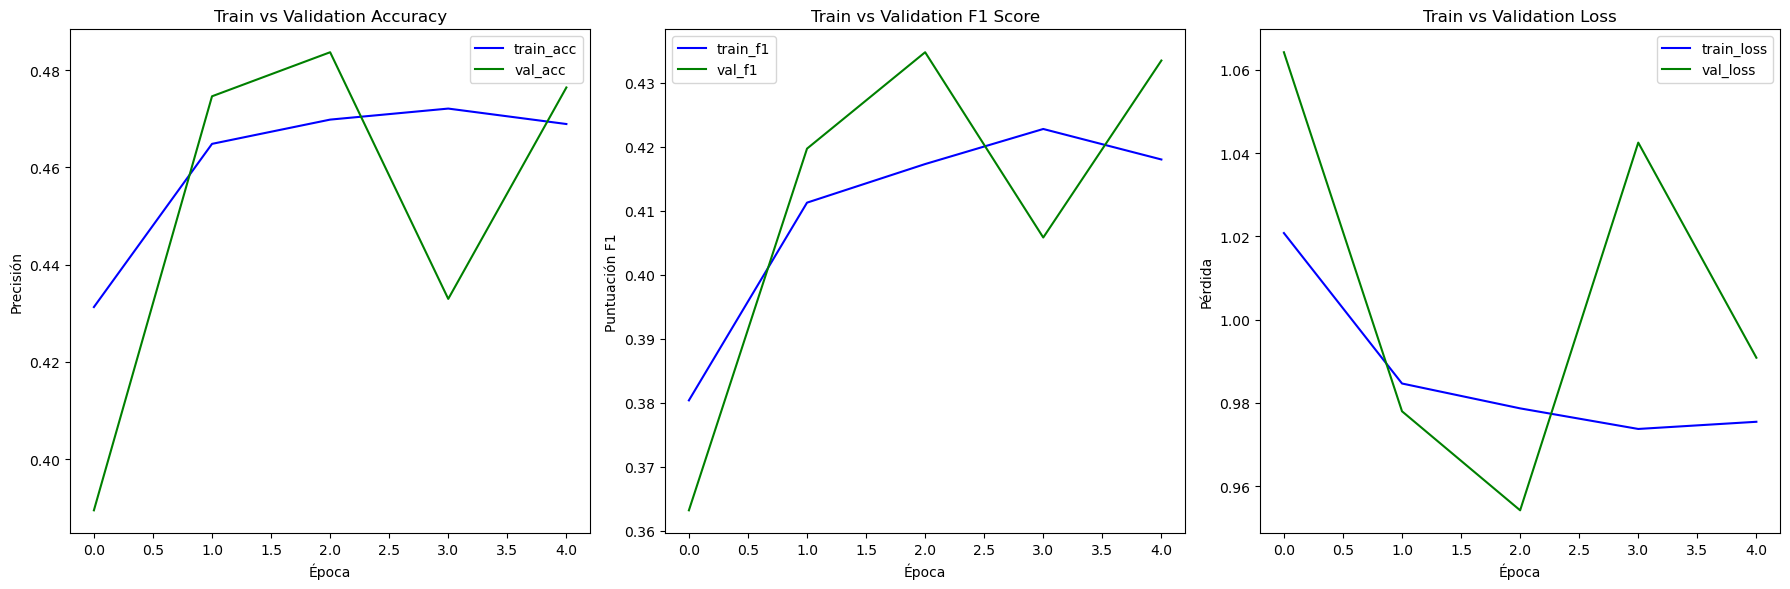

In [8]:
from torch import optim

# Define the loss function and optimizer
size = len(train_data)
loss_weights=torch.Tensor(
[size/1283,size/637,size/837]
).to(device)
loss_fn = nn.CrossEntropyLoss(weight= loss_weights)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 5

# Lists to store training and validation results
train_acc = []
train_f1 = []
train_loss = []


val_acc = []
val_f1 = []
val_loss = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")
    
    # Training phase
    acc, f1, loss = train(train_dataloader, model, loss_fn, optimizer)
    
    train_acc.append(acc)
    train_f1.append(f1)
    train_loss.append(loss)
    
    # Validation phase
    acc, f1, loss = validate(val_dataloader, model, loss_fn)
    val_acc.append(acc)
    val_f1.append(f1)
    val_loss.append(loss)
    scheduler.step(loss)
    
    print(f"Validation accuraccy: {acc:.3f} | Validation F1-Score: {f1:.3f} | Validation mean_loss: {loss:.4f}\n-------------------------------")
    

print("Training and Validation Done!")

test_acc, test_f1, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f} | Test F1-Score: {test_f1:.3f} | Test loss: {test_loss:.3f}\n-------------------------------")

# Save the trained model
torch.save(model.state_dict(), MODELS_DIR + "pre_model_cnn.pth")
print("Model saved as model_cnn.pth")
draw_metrics(train_acc, val_acc, train_f1, val_f1, train_loss, val_loss)


# Transfer Learning: ResNet18 y EfficientNet_V2_S

## ResNet18

In [9]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Grayscale
import numpy as np

# Instanciamos el modelo ResNet18 con los pesos por defecto
weights=ResNet18_Weights.DEFAULT
auto_transforms = weights.transforms()

# Cargamos el dataset con las transformaciones originales
transform=Compose([
    Grayscale(num_output_channels = 3),
    Resize((512, 512)),
    RandomRotation(30),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    auto_transforms,
])

train_data = datasets.ImageFolder(DATASET_DIR+'training',transform= transform)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = data.random_split(train_data, [train_size, val_size])

test_dataset = datasets.ImageFolder(DATASET_DIR+'test', transform= transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Estructura de los batches
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Creamos el modelo y congelamos parámetros de la red
model = resnet18(weights=weights).to(device)
for name, para in model.named_parameters():
    para.requires_grad = False

# Cambiamos la capa superior con una capa Lineal con 3 clases de salida
num_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=num_features,
                    out_features=3,
                    bias=True).to(device)

Shape of X [N, C, H, W]: torch.Size([50, 3, 224, 224])
Shape of y: torch.Size([50]) torch.int64


Epoch 1/5
-------------------------------
Training accuraccy: 0.6390 | Training F1-Score: 0.6289 | Training mean_loss: 0.8266
-------------------------------
Validation accuraccy: 0.384 | Validation F1-Score: 0.303 | Validation mean_loss: 1.3777
-------------------------------
Epoch 2/5
-------------------------------
Training accuraccy: 0.7796 | Training F1-Score: 0.7692 | Training mean_loss: 0.6107
-------------------------------
Validation accuraccy: 0.469 | Validation F1-Score: 0.422 | Validation mean_loss: 1.0560
-------------------------------
Epoch 3/5
-------------------------------
Training accuraccy: 0.8113 | Training F1-Score: 0.8024 | Training mean_loss: 0.5248
-------------------------------
Validation accuraccy: 0.558 | Validation F1-Score: 0.532 | Validation mean_loss: 0.8856
-------------------------------
Epoch 4/5
-------------------------------
Training accuraccy: 0.8259 | Training F1-Score: 0.8178 | Training mean_loss: 0.4848
-------------------------------
Validati

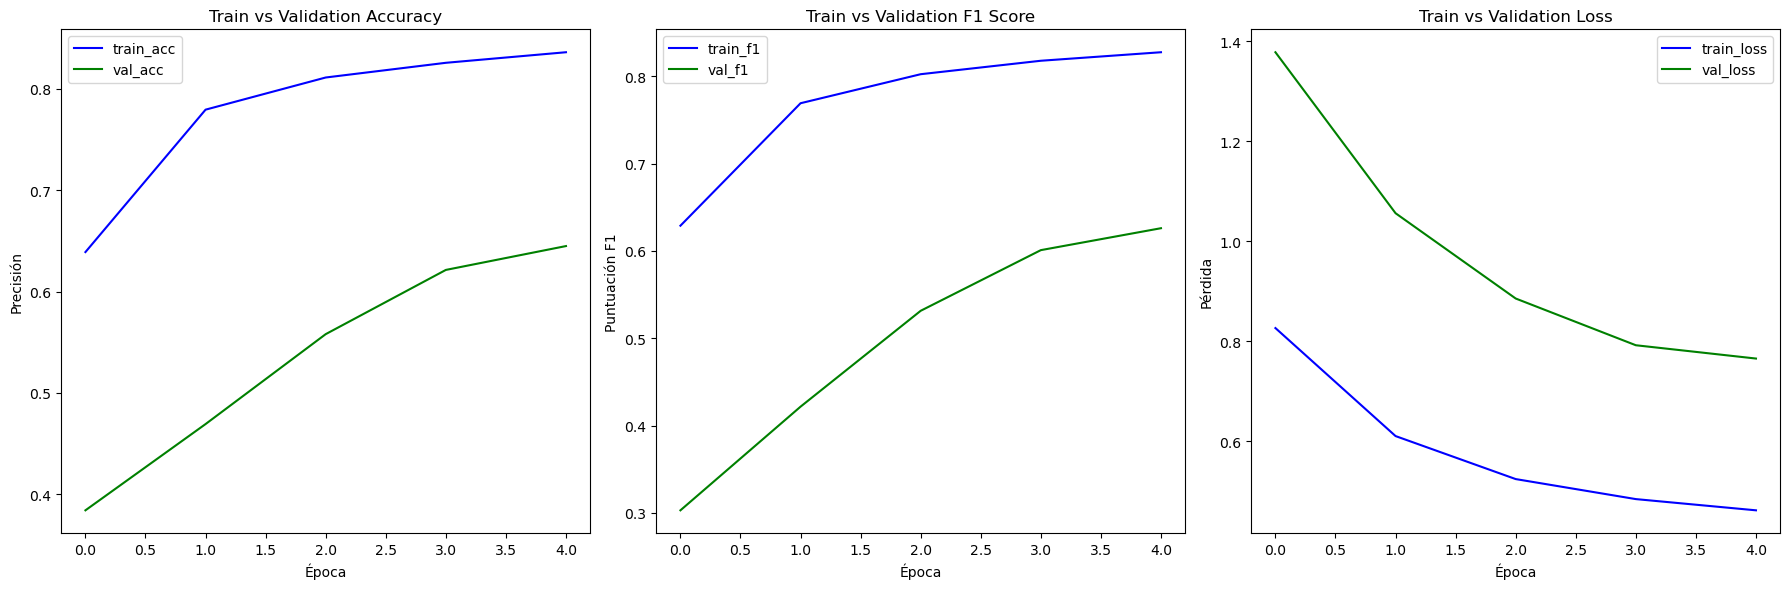

In [10]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 5

# Lists to store training and validation results
train_acc = []
train_f1 = []
train_loss = []


val_acc = []
val_f1 = []
val_loss = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")
    
    # Training phase
    acc, f1, loss = train(train_dataloader, model, loss_fn, optimizer)
    
    train_acc.append(acc)
    train_f1.append(f1)
    train_loss.append(loss)
    
    # Validation phase
    acc, f1, loss = validate(val_dataloader, model, loss_fn)
    val_acc.append(acc)
    val_f1.append(f1)
    val_loss.append(loss)
    scheduler.step(loss)
    
    print(f"Validation accuraccy: {acc:.3f} | Validation F1-Score: {f1:.3f} | Validation mean_loss: {loss:.4f}\n-------------------------------")
    

print("Training and Validation Done!")

test_acc, test_f1, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f} | Test F1-Score: {test_f1:.3f} | Test loss: {test_loss:.3f}\n-------------------------------")

# Save the trained model
torch.save(model.state_dict(), MODELS_DIR + "pre_Res_net18.pth")
print("Model saved as model_cnn.pth")
draw_metrics(train_acc, val_acc, train_f1, val_f1, train_loss, val_loss)

## Efficient_Net

In [11]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.transforms import Compose, Grayscale
import numpy as np

# Instanciamos el modelo ResNet18 con los pesos por defecto
weights=EfficientNet_V2_S_Weights.DEFAULT
auto_transforms = weights.transforms()

# Cargamos el dataset con las transformaciones originales
transform=Compose([
    Grayscale(num_output_channels = 3),
    Resize((512, 512)),
    RandomRotation(30),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    auto_transforms,
])

train_data = datasets.ImageFolder(DATASET_DIR+'training',transform= transform)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = data.random_split(train_data, [train_size, val_size])

test_dataset = datasets.ImageFolder(DATASET_DIR+'test', transform= transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Estructura de los batches
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Creamos el modelo y congelamos parámetros de la red
model = efficientnet_v2_s(weights=weights).to(device)
for name, para in model.named_parameters():
    para.requires_grad = False

# Cambiamos la capa superior con una capa Lineal con 3 clases de salida
model.classifier = torch.nn.Linear(in_features=1280,
                    out_features=3,
                    bias=True).to(device)

Shape of X [N, C, H, W]: torch.Size([50, 3, 384, 384])
Shape of y: torch.Size([50]) torch.int64


Epoch 1/5
-------------------------------
Training accuraccy: 0.5669 | Training F1-Score: 0.5553 | Training mean_loss: 1.0116
-------------------------------
Validation accuraccy: 0.667 | Validation F1-Score: 0.641 | Validation mean_loss: 0.9607
-------------------------------
Epoch 2/5
-------------------------------
Training accuraccy: 0.7719 | Training F1-Score: 0.7527 | Training mean_loss: 0.8632
-------------------------------
Validation accuraccy: 0.808 | Validation F1-Score: 0.791 | Validation mean_loss: 0.8039
-------------------------------
Epoch 3/5
-------------------------------
Training accuraccy: 0.7941 | Training F1-Score: 0.7762 | Training mean_loss: 0.7751
-------------------------------
Validation accuraccy: 0.801 | Validation F1-Score: 0.783 | Validation mean_loss: 0.7448
-------------------------------
Epoch 4/5
-------------------------------
Training accuraccy: 0.8113 | Training F1-Score: 0.7934 | Training mean_loss: 0.7111
-------------------------------
Validati

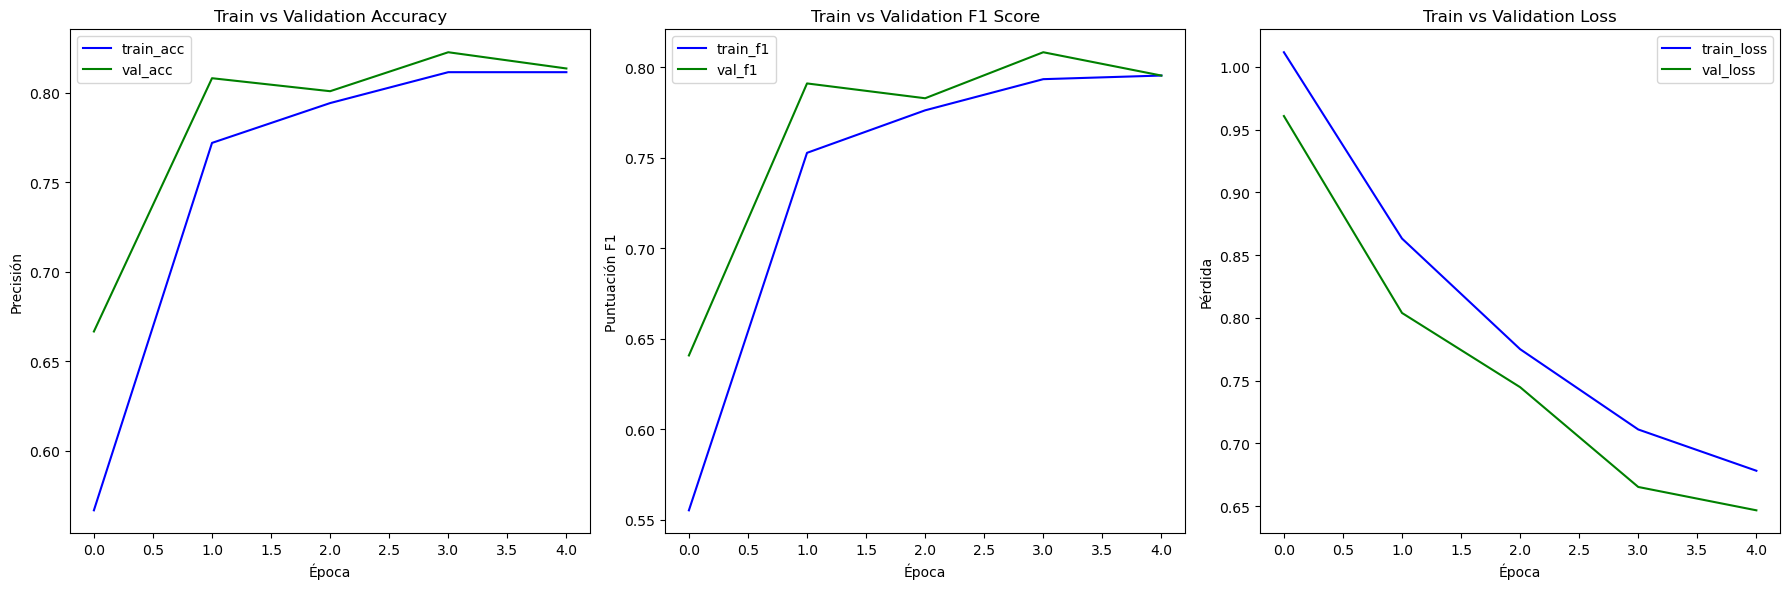

In [12]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 5

# Lists to store training and validation results
train_acc = []
train_f1 = []
train_loss = []


val_acc = []
val_f1 = []
val_loss = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")
    
    # Training phase
    acc, f1, loss = train(train_dataloader, model, loss_fn, optimizer)
    
    train_acc.append(acc)
    train_f1.append(f1)
    train_loss.append(loss)
    
    # Validation phase
    acc, f1, loss = validate(val_dataloader, model, loss_fn)
    val_acc.append(acc)
    val_f1.append(f1)
    val_loss.append(loss)
    scheduler.step(loss)
    
    print(f"Validation accuraccy: {acc:.3f} | Validation F1-Score: {f1:.3f} | Validation mean_loss: {loss:.4f}\n-------------------------------")
    

print("Training and Validation Done!")

test_acc, test_f1, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f} | Test F1-Score: {test_f1:.3f} | Test loss: {test_loss:.3f}\n-------------------------------")

# Save the trained model
torch.save(model.state_dict(), MODELS_DIR + "pre_Eff_net.pth")
print("Model saved as pre_Eff_net.pth")
draw_metrics(train_acc, val_acc, train_f1, val_f1, train_loss, val_loss)

### Entrenamiento Final

Dados los resultados se ha escogido EfficientNet como modelo final. En primer lugar intentaremos llegar a un buen modelo sin entrenar las capas convolutivas, tan solo la última.

In [16]:
# Instanciamos el modelo ResNet18 con los pesos por defecto
weights=EfficientNet_V2_S_Weights.DEFAULT
auto_transforms = weights.transforms()

# Cargamos el dataset con las transformaciones originales
transform=Compose([
    Grayscale(num_output_channels = 3),
    Resize((512, 512)),
    RandomRotation(30),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    auto_transforms,
])

train_data = datasets.ImageFolder(DATASET_DIR+'training',transform= transform)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = data.random_split(train_data, [train_size, val_size])

test_dataset = datasets.ImageFolder(DATASET_DIR+'test', transform= transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Estructura de los batches
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Creamos el modelo y congelamos parámetros de la red
model = efficientnet_v2_s(weights=weights).to(device)
for name, para in model.named_parameters():
    para.requires_grad = False
    

# Cambiamos la capa superior con una capa Lineal con 3 clases de salida
model.classifier = torch.nn.Linear(in_features=1280,
                    out_features=3,
                    bias=True).to(device)
#Cargamos el modelo que empezamos a entrenar antes.
model_path = 'models/pre_Eff_net.pth'
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

Shape of X [N, C, H, W]: torch.Size([50, 3, 384, 384])
Shape of y: torch.Size([50]) torch.int64


<All keys matched successfully>

Epoch 1/30
-------------------------------
Training accuraccy: 0.8122 | Training F1-Score: 0.7968 | Training mean_loss: 0.6417
-------------------------------
Validation accuraccy: 0.808 | Validation F1-Score: 0.792 | Validation mean_loss: 0.6271
-------------------------------
Epoch 2/30
-------------------------------
Training accuraccy: 0.8204 | Training F1-Score: 0.8059 | Training mean_loss: 0.6175
-------------------------------
Validation accuraccy: 0.812 | Validation F1-Score: 0.797 | Validation mean_loss: 0.5970
-------------------------------
Epoch 3/30
-------------------------------
Training accuraccy: 0.8259 | Training F1-Score: 0.8105 | Training mean_loss: 0.5970
-------------------------------
Validation accuraccy: 0.803 | Validation F1-Score: 0.790 | Validation mean_loss: 0.5783
-------------------------------
Epoch 4/30
-------------------------------
Training accuraccy: 0.8240 | Training F1-Score: 0.8108 | Training mean_loss: 0.5775
-------------------------------
Vali

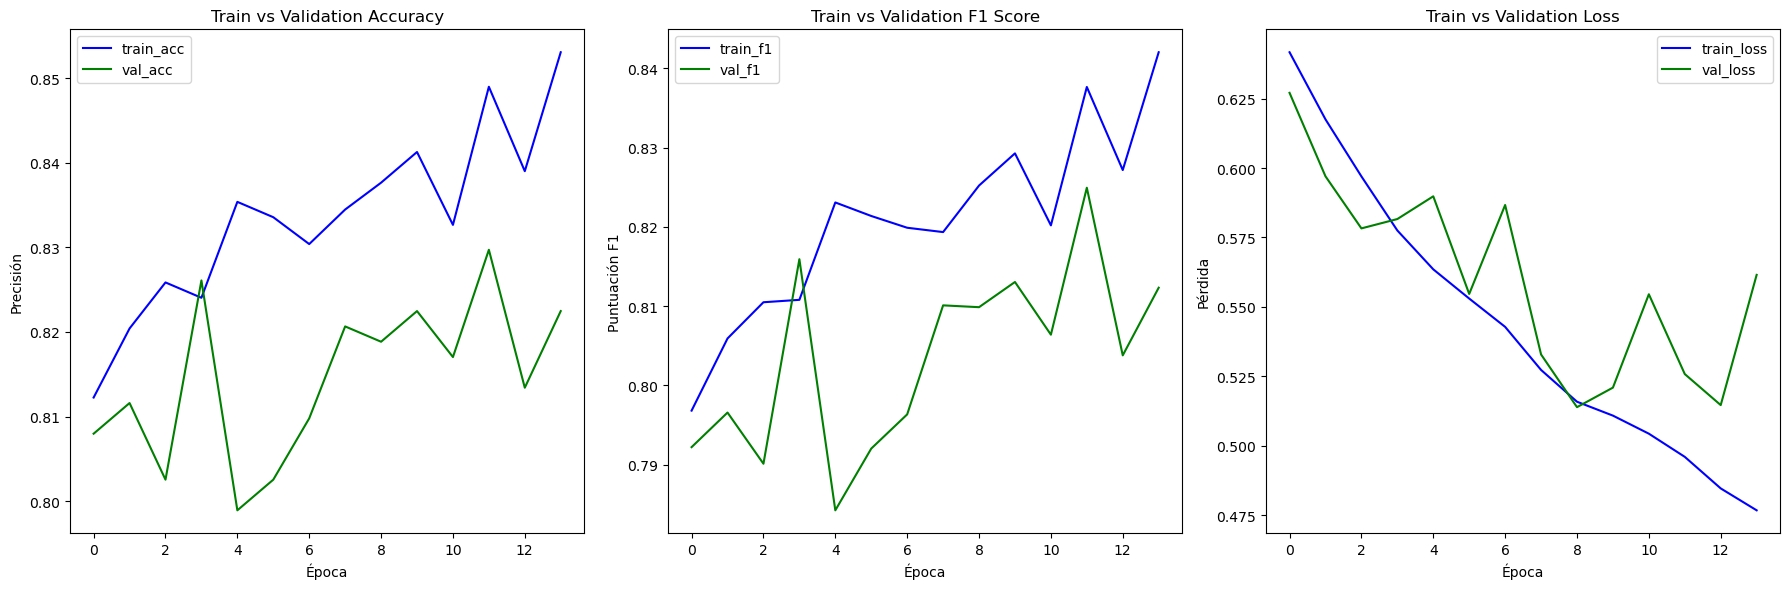

In [17]:
from torch import optim

patience = 5  # Number of epochs with no improvement after which training will be stopped
best_validation_loss = float('inf')
current_patience = 0

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 30

# Lists to store training and validation results
train_acc = []
train_f1 = []
train_loss = []


val_acc = []
val_f1 = []
val_loss = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")
    
    # Training phase
    acc, f1, loss = train(train_dataloader, model, loss_fn, optimizer)
    
    train_acc.append(acc)
    train_f1.append(f1)
    train_loss.append(loss)
    
    # Validation phase
    acc, f1, loss = validate(val_dataloader, model, loss_fn)
    
    if loss < best_validation_loss:
        best_validation_loss = loss
        # Save the model's weights
        torch.save(model.state_dict(), MODELS_DIR + 'best_model.pth')  # You can change the file name as needed
        current_patience = 0
    else:
        current_patience += 1
    
    val_acc.append(acc)
    val_f1.append(f1)
    val_loss.append(loss)
    scheduler.step(loss)
    
    print(f"Validation accuraccy: {acc:.3f} | Validation F1-Score: {f1:.3f} | Validation mean_loss: {loss:.4f}\n-------------------------------")
    # Check early stopping condition
    if current_patience >= patience:
        print(f"Early stopping after 5 epochs without improvement.")
        break
    

print("Training and Validation Done!")

test_acc, test_f1, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f} | Test F1-Score: {test_f1:.3f} | Test loss: {test_loss:.3f}\n-------------------------------")


print("Model saved as best_model.pth")
draw_metrics(train_acc, val_acc, train_f1, val_f1, train_loss, val_loss)

Podemos ver que no hubo gran mejoria, por lo que realizaremos fine tuning.

In [ ]:
# Creamos el modelo y congelamos parámetros de la red, menos la última capas convolutiva y la fully connected
model = resnet18(weights=weights).to(device)
for name, param in model.named_parameters():
    if not name.startswith('layer4') and not name.startswith('fc'):
        param.requires_grad = False
    

# Cambiamos la capa superior con una capa Lineal con 3 clases de salida
num_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=num_features,
                    out_features=3,
                    bias=True).to(device)

#Cargamos el modelo que empezamos a entrenar antes.
model_path = 'models/best_model.pth'
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Epoch 1/30
-------------------------------
Training accuraccy: 0.8821 | Training F1-Score: 0.8728 | Training mean_loss: 0.3180
-------------------------------
Validation accuraccy: 0.897 | Validation F1-Score: 0.890 | Validation mean_loss: 0.2823
-------------------------------
Epoch 2/30
-------------------------------
Training accuraccy: 0.9075 | Training F1-Score: 0.8996 | Training mean_loss: 0.2435
-------------------------------
Validation accuraccy: 0.911 | Validation F1-Score: 0.903 | Validation mean_loss: 0.2116
-------------------------------
Epoch 3/30
-------------------------------
Training accuraccy: 0.9320 | Training F1-Score: 0.9254 | Training mean_loss: 0.1935
-------------------------------
Validation accuraccy: 0.935 | Validation F1-Score: 0.929 | Validation mean_loss: 0.1893
-------------------------------
Epoch 4/30
-------------------------------
Training accuraccy: 0.9433 | Training F1-Score: 0.9382 | Training mean_loss: 0.1480
-------------------------------
Vali

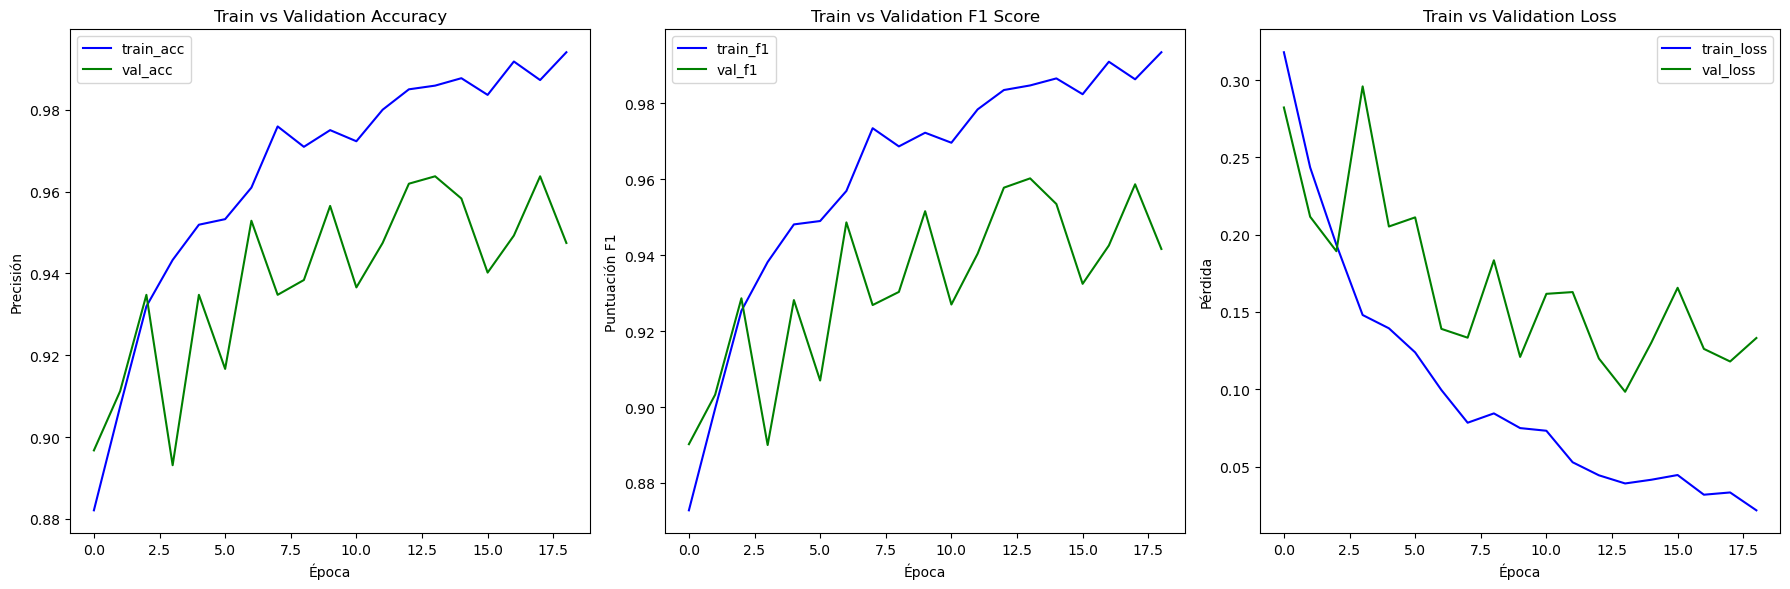

In [ ]:
from torch import optim

patience = 5  # Number of epochs with no improvement after which training will be stopped
best_validation_loss = float('inf')
current_patience = 0

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 30

# Lists to store training and validation results
train_acc = []
train_f1 = []
train_loss = []


val_acc = []
val_f1 = []
val_loss = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")
    
    # Training phase
    acc, f1, loss = train(train_dataloader, model, loss_fn, optimizer)
    
    train_acc.append(acc)
    train_f1.append(f1)
    train_loss.append(loss)
    
    # Validation phase
    acc, f1, loss = validate(val_dataloader, model, loss_fn)
    
    if loss < best_validation_loss:
        best_validation_loss = loss
        # Save the model's weights
        torch.save(model.state_dict(), MODELS_DIR + 'best_model.pth')  # You can change the file name as needed
        current_patience = 0
    else:
        current_patience += 1
    
    val_acc.append(acc)
    val_f1.append(f1)
    val_loss.append(loss)
    scheduler.step(loss)
    
    print(f"Validation accuraccy: {acc:.3f} | Validation F1-Score: {f1:.3f} | Validation mean_loss: {loss:.4f}\n-------------------------------")
    # Check early stopping condition
    if current_patience >= patience:
        print(f"Early stopping after 5 epochs without improvement.")
        break
    

print("Training and Validation Done!")

test_acc, test_f1, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f} | Test F1-Score: {test_f1:.3f} | Test loss: {test_loss:.3f}\n-------------------------------")


print("Model saved as best_model.pth")

draw_metrics(train_acc, val_acc, train_f1, val_f1, train_loss, val_loss)